# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json

from PIL import Image
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
###
load_dataset = False
###

if load_dataset:
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
    !mkdir -p /content/drive/MyDrive/TuSimple
    !cd /content/drive/MyDrive/TuSimple
    !kaggle datasets download -d manideep1108/tusimple
    !unzip \*.zip && rm *.zip

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [4]:
DEFAULT_SIZE = (256, 512)
import torch


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        pass

    def __getitem__(self, idx):
        # TODO
        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]

    def __len__(self):
        # TODO
        pass

In [5]:
###
DEFAULT_SIZE = (256, 512)[::-1]
DATASET_PATH = '/content/drive/MyDrive/TuSimple/train_set'
###

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=DATASET_PATH, train=True, size=DEFAULT_SIZE):
        self._dataset_path = dataset_path
        self._seg_dataset_path = os.path.join(dataset_path, 'segmentation')
        self._train = train
        self._size = size
        self._data_list = self._load_data_list()
        self._transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, saturation=0.2)
        ])


    def __len__(self):
        return len(self._data_list)


    def __getitem__(self, idx):
        raw_file, lanes, h_samples = self._data_list[idx]
        img_path = os.path.join(self._dataset_path, raw_file)
        img = cv2.imread(img_path)
        original_shape = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self._size, interpolation=cv2.INTER_NEAREST)

        # if self._train:
        #     img = self._apply_augmentations(img)

        # segmentation_path = os.path.join(self._seg_dataset_path, os.path.dirname(raw_file))
        # instance_seg_path = os.path.join(segmentation_path, f'{self._size[0]}_{self._size[1]}_instance_seg.png')
        # semantic_seg_path = os.path.join(segmentation_path, f'{self._size[0]}_{self._size[1]}_semantic_seg.png')

        # if not os.path.exists(instance_seg_path) or not os.path.exists(semantic_seg_path):
        #     instance_seg, semantic_seg = self._generate_segmentations(lanes, h_samples, original_shape)
        #     os.makedirs(os.path.dirname(instance_seg_path), exist_ok=True)
        #     os.makedirs(os.path.dirname(semantic_seg_path), exist_ok=True)
        #     cv2.imwrite(instance_seg_path, instance_seg)
        #     cv2.imwrite(semantic_seg_path, semantic_seg)
        # else:
        #     instance_seg = cv2.imread(instance_seg_path, cv2.IMREAD_GRAYSCALE)
        #     semantic_seg = cv2.imread(semantic_seg_path, cv2.IMREAD_GRAYSCALE)


        instance_seg, semantic_seg = self._generate_segmentations(lanes, h_samples, original_shape)

        img = transforms.ToTensor()(img) #.permute(1, 2, 0)
        instance_seg = transforms.ToTensor()(instance_seg) #.permute(1, 2, 0)
        semantic_seg = transforms.ToTensor()(semantic_seg).squeeze() #.permute(1, 2, 0)

        return img, semantic_seg, instance_seg


    def _load_data_list(self):
        data_list = []

        if self._train:
            file_list = [f'label_data_{suffix}.json' for suffix in ('0313', '0531')]
        else:
            file_list = [f'label_data_{suffix}.json' for suffix in ('0601',)]

        for json_file in os.listdir(self._dataset_path):
            if json_file in file_list:
                with open(os.path.join(self._dataset_path, json_file), 'r') as f:
                    for line in f:
                        label_data = json.loads(line)

                        lanes = label_data["lanes"]
                        h_samples = label_data["h_samples"]
                        raw_file = label_data["raw_file"]

                        data_list.append((raw_file, lanes, h_samples))

        return data_list


    def _apply_augmentations(self, img):
        if self._transforms:
            img = self._transforms(Image.fromarray(img))
        return img


    def _generate_segmentations(self, lanes, h_samples, original_shape, thickness=5):

        instance_seg = np.zeros(original_shape, dtype=np.uint8)
        semantic_seg = np.zeros(original_shape, dtype=np.uint8)

        for idx, lane in enumerate(lanes):
            lane_points = [(x, y) for x, y in zip(lane, h_samples) if x != -2]
            lane_points = np.array([lane_points], dtype=np.int32)
            cv2.polylines(instance_seg, [lane_points], isClosed=False, color=idx + 1, thickness=thickness)
            cv2.polylines(semantic_seg, [lane_points], isClosed=False, color=1, thickness=thickness)

        instance_seg = cv2.resize(instance_seg, self._size, interpolation=cv2.INTER_NEAREST)
        semantic_seg = cv2.resize(semantic_seg, self._size, interpolation=cv2.INTER_NEAREST)

        return instance_seg, semantic_seg



In [6]:
lanes_trainset = LaneDataset()
lanes_trainset.__len__()

3216

In [7]:
img, semantic_seg, instance_seg = lanes_trainset[100]
img.shape, semantic_seg.shape, instance_seg.shape

(torch.Size([1, 256, 512]), torch.Size([256, 512]), torch.Size([1, 256, 512]))

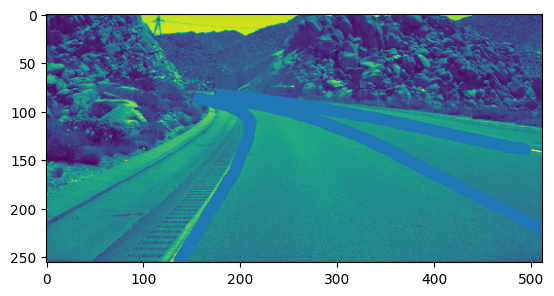

In [8]:
plt.imshow(img.permute(1, 2, 0))
plt.scatter(semantic_seg.nonzero(as_tuple=True)[1],
            semantic_seg.nonzero(as_tuple=True)[0])

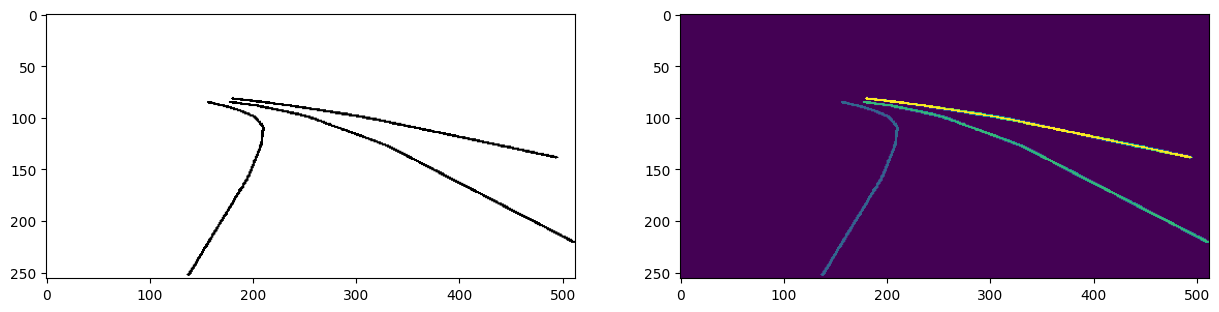

In [9]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.imshow(semantic_seg.permute(0, 1), cmap=plt.cm.binary)
plt.subplot(1, 2, 2)
plt.imshow(instance_seg.permute(1, 2, 0))

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [10]:
class ENet(nn.Module):
    def __init__(self):
        super(ENet, self).__init__()

    def forward(self, x):
      # TODO
      pass




In [11]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """
    ENet: A deep neural network architecture for real-time semantic segmentation.

    Args:
        binary_seg (int): Number of channels for binary segmentation output.
        embedding_dim (int): Number of channels for embedding output.
        encoder_relu (bool, optional): Whether to use ReLU activation in the encoder. Defaults to False.
        decoder_relu (bool, optional): Whether to use ReLU activation in the decoder. Defaults to True.

    Attributes:
        initial_block (InitialBlock): Initial block of the ENet architecture.
        downsample1_0 to dilated_embedding_3_7 (Bottleneck modules): Components of the ENet architecture.
        upsample_binary_4_0 to embedding_transposed_conv (UpsamplingBottleneck and ConvTranspose2d modules): Components of the ENet architecture.
    """
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        """
        Forward pass through the ENet model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Binary logits and instance logits.
        """
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_logits, instance_logits

In [12]:
model = ENet(2, 5)

semantic_seg_pred, instance_seg_pred = model(torch.randn((1, 1, 256, 512)))
semantic_seg_pred.shape, instance_seg_pred.shape

(torch.Size([1, 2, 256, 512]), torch.Size([1, 5, 256, 512]))

In [13]:
semantic_seg_pred, instance_seg_pred = model(img[None, ...])
semantic_seg_pred.shape, instance_seg_pred.shape

(torch.Size([1, 2, 256, 512]), torch.Size([1, 5, 256, 512]))

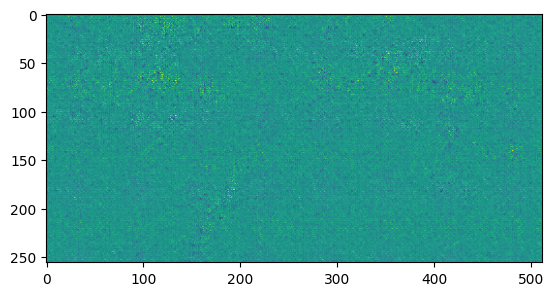

In [14]:
plt.imshow(instance_seg_pred.view(1, -1, 256, 512)[:, 0, :, :].permute(1, 2, 0).detach().numpy())

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [15]:
class DiscriminativeLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(DiscriminativeLoss, self).__init__(size_average=size_average)
        # TODO

    def forward(self, input, target):
        # TODO
        pass

In [16]:

class DiscriminativeLoss(torch.nn.modules.loss._Loss):
    def __init__(self, delta_var=0.5, delta_dist=3, norm=2, alpha=1.0, beta=1.0, gamma=0.001, device='cuda', reduction="mean", n_clusters=4):
        """
        Discriminative Loss constructor.

        Args:
            delta_var (float): Variance threshold. Default is 0.5.
            delta_dist (float): Distance threshold. Default is 3.
            norm (int): Norm order for distance computation. Should be 1 or 2. Default is 2.
            alpha (float): Weight for variance loss. Default is 1.0.
            beta (float): Weight for distance loss. Default is 1.0.
            gamma (float): Weight for regularization loss. Default is 0.001.
            device (str): Device for computation, e.g., 'cuda' or 'cpu'. Default is 'cuda'.
            reduction (str): Specifies the reduction strategy. Default is "mean".
            n_clusters (int): Number of clusters. Default is 4.
        """
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters


    def forward(self, input_data, target_data):
        """
        Forward method to calculate the Discriminative Loss.

        Args:
            input_data (torch.Tensor): Model predictions.
            target_data (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: Computed Discriminative Loss.
        """
        return self._calculate_loss(input_data, target_data)

    def _calculate_loss(self, input_data, target_data):
        """
        Calculate Discriminative Loss.

        Args:
            input_data (torch.Tensor): Model predictions.
            target_data (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: Computed Discriminative Loss.
        """
        num_samples = target_data.size(0)
        total_distance_loss = torch.tensor(0.).to(self.device)
        total_variance_loss = torch.tensor(0.).to(self.device)
        total_regularization_loss = torch.tensor(0.).to(self.device)

        for i in range(num_samples):
            clusters = []
            sample_embedding = input_data[i, :, :, :]
            sample_label = target_data[i, :, :].squeeze()
            num_clusters = len(sample_label.unique()) - 1
            cluster_values = sample_label.unique()[1:]
            sample_label = sample_label.view(sample_label.size(0) * sample_label.size(1))
            sample_embedding = sample_embedding.view(-1, sample_embedding.size(1) * sample_embedding.size(2))
            variance_loss = torch.tensor(0.).to(self.device)
            distance_loss = torch.tensor(0.).to(self.device)
            regularization_loss = torch.tensor(0.).to(self.device)

            for j in range(num_clusters):
                indices = (sample_label == cluster_values[j]).nonzero().squeeze()
                cluster_elements = torch.index_select(sample_embedding, 1, indices)
                Nc = cluster_elements.size(1)
                mean_cluster = cluster_elements.mean(dim=1, keepdim=True)
                clusters.append(mean_cluster)
                variance_loss += torch.pow((torch.clamp(torch.norm(cluster_elements - mean_cluster) - self.delta_var, min=0.)), 2).sum() / Nc
                regularization_loss += torch.sum(torch.abs(mean_cluster))

            for index in range(num_clusters):
                for idx, cluster in enumerate(clusters):
                    if index == idx:
                        continue
                    else:
                        distance = torch.norm(clusters[index] - cluster)
                        distance_loss += torch.pow(torch.clamp(self.delta_dist - distance, min=0.), 2)

            total_variance_loss += variance_loss / num_clusters
            total_distance_loss += distance_loss / (num_clusters * (num_clusters - 1))
            total_regularization_loss += regularization_loss / num_clusters

        return self.alpha * (total_variance_loss / num_samples) + self.beta * (total_distance_loss / num_samples) + self.gamma * (total_regularization_loss / num_samples)


In [17]:
DiscriminativeLoss()(instance_seg_pred, instance_seg)

tensor(10.4135, device='cuda:0', grad_fn=<AddBackward0>)

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [18]:
# TODO: Train segmentation and instance segmentation

In [103]:
# Initializing

###
batch_size = 8
###

train_dataset = LaneDataset()
eval_dataset = LaneDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

enet = ENet(2, 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enet.to(device);

In [104]:
# Training


###
learning_rate = 1e-4
epochs = 50
log_interval = 50
###

semantic_loss_fn = CrossEntropyLoss()
instance_loss_fn = DiscriminativeLoss()
optimizer = optim.Adam(enet.parameters(), lr=learning_rate)


for epoch in tqdm(range(epochs)):
    enet.train()
    losses = []

    for batch_idx, (input_data, target_semantic, target_instance) in tqdm(enumerate(train_loader)):
        input_data, target_semantic, target_instance = input_data.to(device), target_semantic.to(device), target_instance.to(device)
        target_semantic = target_semantic.long()
        optimizer.zero_grad()
        output_semantic, output_instance = enet(input_data)

        semantic_loss = semantic_loss_fn(output_semantic, target_semantic)
        instance_loss = instance_loss_fn(output_instance, target_instance)
        total_loss = semantic_loss + instance_loss

        total_loss.backward()
        optimizer.step()
        losses.append((semantic_loss.detach().cpu(), instance_loss.detach().cpu(), total_loss.item()))

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Avg Losses: {np.array(losses).mean(axis=0)}")


torch.save(enet.state_dict(),f"{DATASET_PATH}/enet_model.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0, Batch 0, Avg Losses: [ 0.62921154 95.92628479 96.55549622]
Epoch 0, Batch 50, Avg Losses: [ 0.55805184 93.31259514 93.87064676]
Epoch 0, Batch 100, Avg Losses: [ 0.50208712 90.62937542 91.13146225]
Epoch 0, Batch 150, Avg Losses: [ 0.4557121  88.28581738 88.7415293 ]
Epoch 0, Batch 200, Avg Losses: [ 0.41562141 85.76551082 86.18113223]
Epoch 0, Batch 250, Avg Losses: [ 0.38168859 80.51361113 80.89529972]
Epoch 0, Batch 300, Avg Losses: [ 0.35262315 74.32109582 74.67371898]
Epoch 0, Batch 350, Avg Losses: [ 0.32753178 68.6417185  68.96925032]
Epoch 0, Batch 400, Avg Losses: [ 0.30545734 63.68131385 63.98677124]


0it [00:00, ?it/s]

Epoch 1, Batch 0, Avg Losses: [ 0.13445014 29.1490097  29.28346062]
Epoch 1, Batch 50, Avg Losses: [ 0.13095406 25.34917199 25.4801261 ]
Epoch 1, Batch 100, Avg Losses: [ 0.12241319 24.06955857 24.19197176]
Epoch 1, Batch 150, Avg Losses: [ 0.11592092 23.02204039 23.13796129]
Epoch 1, Batch 200, Avg Losses: [ 0.10964916 21.71248495 21.82213411]
Epoch 1, Batch 250, Avg Losses: [ 0.10405113 20.4736777  20.57772883]
Epoch 1, Batch 300, Avg Losses: [ 0.09918189 19.24486994 19.34405183]
Epoch 1, Batch 350, Avg Losses: [ 0.09478112 18.24679431 18.34157543]
Epoch 1, Batch 400, Avg Losses: [ 0.09039654 17.33760196 17.4279985 ]


0it [00:00, ?it/s]

Epoch 2, Batch 0, Avg Losses: [ 0.06357262 10.79933357 10.86290646]
Epoch 2, Batch 50, Avg Losses: [ 0.05360007 10.65176906 10.70536911]
Epoch 2, Batch 100, Avg Losses: [ 0.051519   10.14318334 10.19470232]
Epoch 2, Batch 150, Avg Losses: [0.04921921 9.69120053 9.7404197 ]
Epoch 2, Batch 200, Avg Losses: [0.04719312 9.24501401 9.2922071 ]
Epoch 2, Batch 250, Avg Losses: [0.04539474 8.90033033 8.94572505]
Epoch 2, Batch 300, Avg Losses: [0.04384441 8.62141235 8.66525674]
Epoch 2, Batch 350, Avg Losses: [0.0422671  8.35588282 8.39814991]
Epoch 2, Batch 400, Avg Losses: [0.04081459 8.13817624 8.17899082]


0it [00:00, ?it/s]

Epoch 3, Batch 0, Avg Losses: [0.03162142 6.09974289 6.13136435]
Epoch 3, Batch 50, Avg Losses: [0.0290092  5.94769792 5.97670715]
Epoch 3, Batch 100, Avg Losses: [0.02746773 5.73481462 5.76228236]
Epoch 3, Batch 150, Avg Losses: [0.02652615 5.69091397 5.71744014]
Epoch 3, Batch 200, Avg Losses: [0.02557045 5.58495076 5.61052121]
Epoch 3, Batch 250, Avg Losses: [0.02485204 5.37053121 5.39538326]
Epoch 3, Batch 300, Avg Losses: [0.0240769  5.24192208 5.26599897]
Epoch 3, Batch 350, Avg Losses: [0.02334069 5.20757296 5.23091364]
Epoch 3, Batch 400, Avg Losses: [0.02261471 5.1315948  5.1542095 ]


0it [00:00, ?it/s]

Epoch 4, Batch 0, Avg Losses: [0.02277772 5.65248966 5.67526722]
Epoch 4, Batch 50, Avg Losses: [0.01684226 4.73131178 4.74815402]
Epoch 4, Batch 100, Avg Losses: [0.01644961 4.60424822 4.62069781]
Epoch 4, Batch 150, Avg Losses: [0.01587364 4.38874031 4.40461394]
Epoch 4, Batch 200, Avg Losses: [0.01529506 4.27170448 4.28699952]
Epoch 4, Batch 250, Avg Losses: [0.01480218 4.10282967 4.11763184]
Epoch 4, Batch 300, Avg Losses: [0.01437053 4.07609344 4.09046396]
Epoch 4, Batch 350, Avg Losses: [0.01401692 3.9912119  4.00522882]
Epoch 4, Batch 400, Avg Losses: [0.01367895 3.92451401 3.93819295]


In [105]:
eval_img, eval_semantic_seg, eval_instance_seg = eval_dataset[10]
eval_img.shape, eval_semantic_seg.shape, eval_instance_seg.shape

(torch.Size([1, 256, 512]), torch.Size([256, 512]), torch.Size([1, 256, 512]))

In [106]:
eval_img = eval_img.to(device)
x_semantic, x_instance = enet(eval_img[None, ...])
x_semantic.shape, x_instance.shape

(torch.Size([1, 2, 256, 512]), torch.Size([1, 5, 256, 512]))

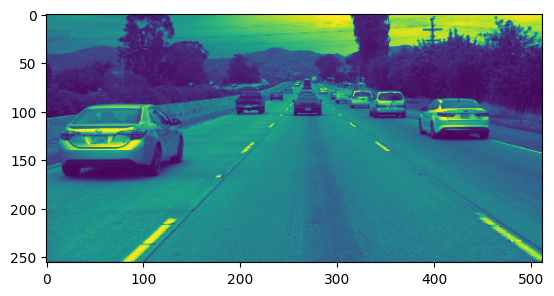

In [89]:
plt.imshow(eval_img
           .permute(1, 2, 0)
           .cpu())

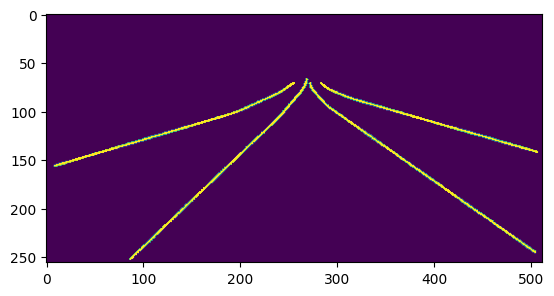

In [90]:
plt.imshow(eval_semantic_seg)

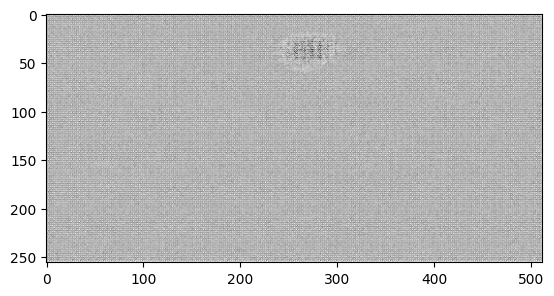

In [111]:
plt.imshow(x_semantic
           .squeeze()[0]
           .cpu()
           .detach()
           .numpy(), cmap=plt.cm.binary)
plt.show()

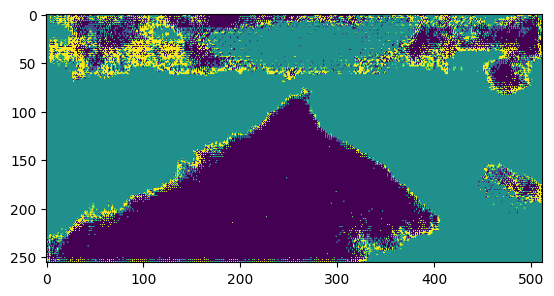

In [108]:
plt.imshow(x_instance
           .squeeze()[:3, :, :]
           .argmax(axis=0)
           .cpu())

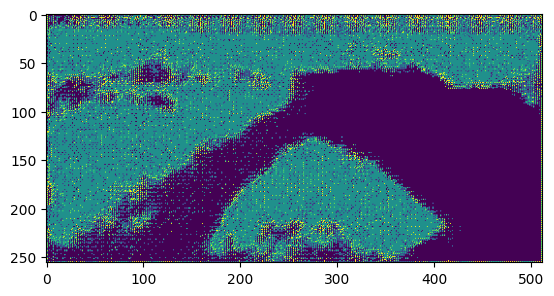

In [102]:
plt.imshow(x_instance
           .squeeze()[:3, :, :]
           .argmax(axis=0)
           .cpu())

The model is not performing well and needs finetuning and, possibly, som loss calculation adaptation.

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [28]:
HNET_DEFAULT_SIZE = (64, 128)
import torch

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        # TODO
        pass

    def __getitem__(self, idx):
        # TODO
        return image, ground_truth_trajectory

    def __len__(self):
        # TODO
        pass

In [29]:
HNET_DEFAULT_SIZE = (64, 128)[::-1]

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=DATASET_PATH, train=True, size=HNET_DEFAULT_SIZE):
        self._dataset_path = dataset_path
        self._train = train
        self._size = size
        self._data_list = self._load_data_list()

    def __getitem__(self, idx):
        raw_file, lanes, h_samples = self._data_list[idx]
        img_path = os.path.join(self._dataset_path, raw_file)
        img = cv2.imread(img_path)
        original_shape = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self._size, interpolation=cv2.INTER_LINEAR)

        ground_truth_trajectory = self._create_ground_truth_trajectory(idx, original_shape)
        img = transforms.ToTensor()(img)

        return img, ground_truth_trajectory


    def __len__(self):
        return len(self._data_list)

    def _load_data_list(self):
        data_list = []

        if self._train:
            file_list = [f'label_data_{suffix}.json' for suffix in ('0313', '0531')]
        else:
            file_list = [f'label_data_{suffix}.json' for suffix in ('0601',)]

        for json_file in os.listdir(self._dataset_path):
            if json_file in file_list:
                with open(os.path.join(self._dataset_path, json_file), 'r') as f:
                    for line in f:
                        label_data = json.loads(line)
                        lanes = label_data["lanes"]
                        h_samples = label_data["h_samples"]
                        raw_file = label_data["raw_file"]
                        data_list.append((raw_file, lanes, h_samples))

        return data_list


    def _create_ground_truth_trajectory(self, idx, original_shape):
        lanes = np.array(self._data_list[idx][1])
        h_samples = np.array(self._data_list[idx][2])
        ground_truth_trajectory = []

        for lane in lanes:
            lane_points = [[0, 0] if point_x == -2 else [point_x, h_samples[idx]]
                          for idx, point_x in enumerate(lane)]

            lane_points = np.array(lane_points).astype(np.float32)
            lane_points[:, 0] *= self._size[0] / original_shape[1]
            lane_points[:, 1] *= self._size[1] / original_shape[0]

            padded_lane_points = np.zeros((56, 2), dtype=np.float32)
            padded_lane_points[:len(lane_points), :] = lane_points

            ground_truth_trajectory.append(padded_lane_points)

        ground_truth_trajectory = np.pad(
            ground_truth_trajectory,
            ((0, 5 - len(ground_truth_trajectory)), (0, 0), (0, 0)),
            mode='constant',
            constant_values=0)

        return torch.tensor(ground_truth_trajectory, dtype=torch.float32).permute(0, 2, 1) # .clone()


In [30]:
homography_dataset = HomographyPredictionDataset()

In [31]:
img, ground_truth_trajectory = homography_dataset[100]
img.shape, ground_truth_trajectory.shape

(torch.Size([3, 64, 128]), torch.Size([5, 2, 56]))

In [32]:
ground_truth_trajectory[1].shape

torch.Size([2, 56])

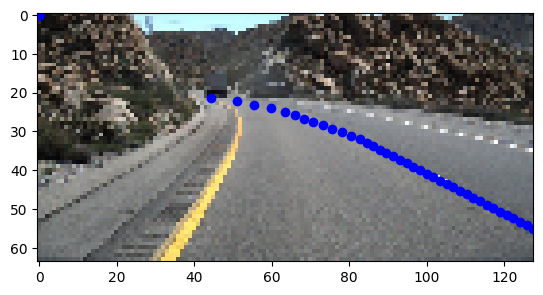

In [33]:
plt.imshow(img.permute(1, 2, 0))
lane_idx = 1
plt.scatter(x=ground_truth_trajectory[lane_idx][0],
            y=ground_truth_trajectory[lane_idx][1],
            c='blue')


Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [34]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [35]:
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

--2024-01-28 18:36:35--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9804, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg [following]
--2024-01-28 18:36:35--  https://miro.medium.com/v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Reusing existing connection to miro.medium.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 91108 (89K) [image/jpeg]
Saving to: ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’

1*b3HiwPg69Rw0L5iIM 100%[===================>]  88.97K  --.-KB/s    in 0.005s  

2024-01-28 18:36:35 (18.8 MB/s) - ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’ saved [91108/91108]



In [36]:
from matplotlib import pyplot as plt
import cv2

In [37]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [38]:
image = cv2.resize(image, (128, 64))

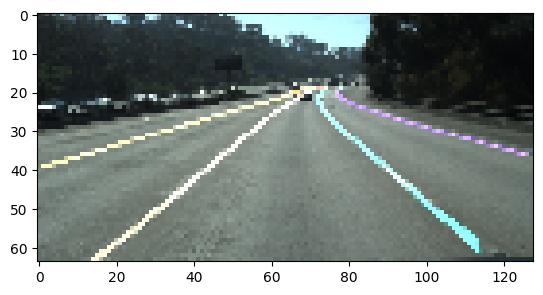

In [39]:
plt.imshow(image)

In [40]:
R_np = R.numpy()

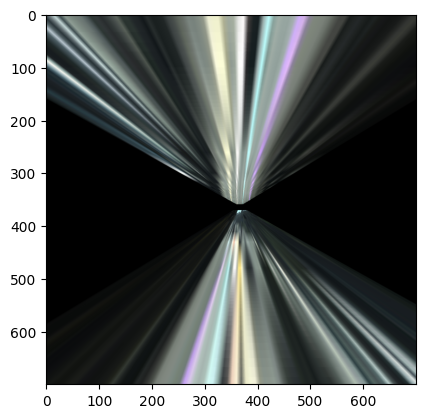

In [41]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [42]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # TODO
    def forward(self, x):
      # TODO
      pass

In [43]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.ln1 = nn.Linear(8192, 1024)
        self.bn7 = nn.BatchNorm1d(1024)

        self.ln2 = nn.Linear(1024, 6)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.conv2(x)
        x = self.relu(self.bn2(x))
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(self.bn3(x))
        x = self.conv4(x)
        x = self.relu(self.bn4(x))
        x = self.maxpool(x)

        x = self.conv5(x)
        x = self.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.relu(self.bn6(x))
        x = self.maxpool(x)


        x = x.view(x.size(0), -1)
        x = self.ln1(x)
        x = self.relu(self.bn7(x))
        x = self.ln2(x)

        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [44]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(HomographyLoss, self).__init__(size_average=size_average)

    def forward(self, input, target):
        # TODO
        pass

In [63]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, reduction_strategy="mean", polynomial_order=2, computation_device=device):
        """
        Homography Loss constructor.

        Args:
            reduction_strategy (str): Specifies the reduction strategy. Default is "mean".
            polynomial_order (int): Order of the polynomial. Default is 2.
            computation_device (str): Device for computation, e.g., 'cuda' or 'cpu'. Default is 'cuda'.
        """
        super(HomographyLoss, self).__init__(reduction=reduction_strategy)
        self.device = torch.device(computation_device)
        self.order = polynomial_order
        self.homography_matrix = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=self.device
        )

    def forward(self, predicted_data, ground_truth_data):
        """
        Compute the Homography Loss.

        Args:
            predicted_data (torch.Tensor): Predicted data.
            ground_truth_data (torch.Tensor): Ground truth data.

        Returns:
            torch.Tensor: Computed Homography Loss.
        """
        losses = []
        for correction_matrix, gt_lanes in zip(predicted_data, ground_truth_data):
            for lane in gt_lanes:
                if lane.sum() == 0:
                    continue

                lane_loss = self.calculate_loss_for_lane(correction_matrix, lane)
                if lane_loss is None:
                    continue

                losses.append(lane_loss)

        return torch.stack(losses).mean()

    def calculate_loss_for_lane(self, correction_matrix, lane_points):
        """
        Calculate Homography Loss for a single lane.

        Args:
            correction_matrix (torch.Tensor): Correction matrix for the lane.
            lane_points (torch.Tensor): Points representing the lane.

        Returns:
            torch.Tensor: Computed Homography Loss for the lane.
        """
        correction_indices = [0, 1, 2, 4, 5, 7]
        correction = correction_matrix.flatten()
        homography = self.homography_matrix.flatten().clone()
        homography[correction_indices] = correction
        homography = homography.reshape((3, 3))

        lane_points = lane_points.T
        index = lane_points.nonzero().flatten().max().item() + 1
        lane_points = lane_points[:index, :]
        ones_column = torch.ones(lane_points.shape[0], device=self.device)
        homogenized_points = torch.column_stack((lane_points, ones_column)).T.to(torch.float32)
        transformed_points = homography @ homogenized_points

        x_transformed = transformed_points[0, :].T
        y_transformed_squares = transformed_points[1, :] ** 2
        y_transformed = transformed_points[1, :]
        augmented_y = torch.column_stack((y_transformed_squares, y_transformed, ones_column))

        weights = torch.linalg.solve(augmented_y.T @ augmented_y, augmented_y.T) @ x_transformed

        x_predicted = augmented_y @ weights
        predicted_homogenized_points = torch.column_stack((x_predicted, y_transformed, ones_column)).T
        reprojected_points = torch.linalg.inv(homography.detach()) @ predicted_homogenized_points

        reprojected_points = torch.div(reprojected_points, reprojected_points[2, :])

        loss = ((lane_points[:, 0].T - reprojected_points[0, :]) ** 2).mean()

        return loss


Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [47]:
# Train the H-Net

In [64]:
# Initializing

###
batch_size = 8
###

train_dataset = HomographyPredictionDataset()
eval_dataset = HomographyPredictionDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

hnet = HNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hnet.to(device)
torch.autograd.set_detect_anomaly(True)

In [66]:
# Training


###
learning_rate = 1e-4
epochs = 20
log_interval = 50
###

loss_fn = HomographyLoss()
optimizer = optim.SGD(hnet.parameters(), lr=5e-4)


for epoch in tqdm(range(epochs)):
    hnet.train()
    losses = []

    for batch_idx, (input_data, ground_truth_trajectory) in tqdm(enumerate(train_loader)):
        input_data, ground_truth_trajectory = input_data.to(device), ground_truth_trajectory.to(device)
        predict_trajectory = hnet(input_data).to(device)

        optimizer.zero_grad()
        loss = loss_fn(predict_trajectory, ground_truth_trajectory)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Avg Loss: {np.array(losses).mean()}")


torch.save(enet.state_dict(), f"{DATASET_PATH}/hnet_model.pth")


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0, Batch 0, Avg Loss: 4785.294921875
Epoch 0, Batch 50, Avg Loss: 4916.430147058823
Epoch 0, Batch 100, Avg Loss: 4896.422329439975
Epoch 0, Batch 150, Avg Loss: 4918.383756725993
Epoch 0, Batch 200, Avg Loss: 4897.64257933963
Epoch 0, Batch 250, Avg Loss: 4892.302945444783
Epoch 0, Batch 300, Avg Loss: 4901.59361130217
Epoch 0, Batch 350, Avg Loss: 6203.582858267673
Epoch 0, Batch 400, Avg Loss: 6038.099702525912


# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [67]:
class LaneDetector:
  def __init__(self, hnet, lanenet):
    pass

  def __call__(self, image, y_positions):
    pass

In [95]:
class LaneDetector:
    """
    LaneDetector class for detecting lanes using ENet and optional homography transformation.

    Args:
        enet (nn.Module): Instance of ENet neural network for binary segmentation and embedding.
        hnet (nn.Module, optional): Instance of HNet neural network for homography transformation. Defaults to None.
        device (str, optional): Device to run the networks on, e.g., "cuda" or "cpu". Defaults to "cuda".
        with_projection (bool, optional): Whether to perform homography projection. Defaults to False.

    Attributes:
        DEFAULT_IMAGE_SIZE (tuple): Default image size.
    """

    DEFAULT_IMAGE_SIZE = DEFAULT_SIZE

    def __init__(self, enet, hnet=None, device="cuda", with_projection=False):
        """
        Initializes the LaneDetector with ENet, optional HNet, device, and projection settings.

        Args:
            enet (nn.Module): Instance of ENet neural network for binary segmentation and embedding.
            hnet (nn.Module, optional): Instance of HNet neural network for homography transformation. Defaults to None.
            device (str, optional): Device to run the networks on, e.g., "cuda" or "cpu". Defaults to "cuda".
            with_projection (bool, optional): Whether to perform homography projection. Defaults to False.
        """
        self._enet = enet
        self._hnet = hnet
        self._default_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )
        self._eps = 1.0
        self._device = device
        self._with_projection = with_projection

    def __call__(self, image, y_positions=None):
        """
        Perform lane detection on the given image.

        Args:
            image (numpy.ndarray): Input image for lane detection.
            y_positions (numpy.ndarray, optional): Y-positions for fitting lanes. Defaults to None.

        Returns:
            tuple: A tuple containing instances_map (numpy.ndarray) and predicted_lanes (numpy.ndarray).
        """
        image = self._preprocess_image(image)
        if y_positions is None:
            y_positions = np.linspace(50, image.shape[2], 30)
        binary_logits, instance_embeddings = self._enet(image)
        segmentation_map = binary_logits.squeeze().argmax(dim=0)
        instances_map = self._cluster(segmentation_map, instance_embeddings)
        lanes = self._extract_lanes(instances_map)

        if self._with_projection:
            projected_lanes = self._project_lanes(lanes)
            coefs = self._fit(projected_lanes)
            y_positions_projected = self._project_y(y_positions)
            fitted_lanes = self._predict_lanes(coefs, y_positions_projected)
            reprojected_lanes = self._reproject(fitted_lanes)
            predicted_lanes = reprojected_lanes
        else:
            coefs = self._fit(lanes)
            fitted_lanes = self._predict_lanes(coefs, y_positions)
            predicted_lanes = fitted_lanes

        predicted_lanes = self._postprocess_result(predicted_lanes)

        return instances_map.cpu().numpy(), predicted_lanes.cpu().numpy()


    def _cluster(self, segmentation_map, instance_embeddings):
        """
        Cluster instances based on segmentation map and instance embeddings.

        Args:
            segmentation_map (torch.Tensor): Segmentation map.
            instance_embeddings (torch.Tensor): Instance embeddings.

        Returns:
            torch.Tensor: Map with instance labels.
        """
        segmentation_map = segmentation_map.flatten()
        instance_embeddings = instance_embeddings.squeeze().permute(1, 2, 0).reshape(segmentation_map.shape[0], -1)
        mask_indices = segmentation_map.nonzero().flatten()
        cluster_data = instance_embeddings[mask_indices].detach().cpu()
        clusterer = DBSCAN(eps=self._eps)
        labels = clusterer.fit_predict(cluster_data)
        labels = torch.tensor(labels, dtype=instance_embeddings.dtype, device=self._device)
        instances_map = torch.zeros(instance_embeddings.shape[0], dtype=instance_embeddings.dtype, device=self._device)
        instances_map[mask_indices] = labels
        instances_map = instances_map.reshape(self.DEFAULT_IMAGE_SIZE[::-1])

        return instances_map


    def _extract_lanes(self, instances_map, scale=False):
        """
        Extract lanes from the instances map.

        Args:
            instances_map (torch.Tensor): Map with instance labels.
            scale (bool, optional): Whether to scale coordinates. Defaults to False.

        Returns:
            list: List of lanes, each represented as a torch.Tensor.
        """
        lanes = []
        lane_indices = instances_map.unique()[1:]
        for index in lane_indices:
            coords = (instances_map == index).nonzero(as_tuple=True)
            if scale:
                coords = [c / 4 for c in coords]
            coords = coords[::-1]
            coords = torch.stack(coords).to(instances_map.dtype)
            lanes.append(coords)

        return lanes


    def _fit(self, lanes):
        """
        Fit lanes using linear regression.

        Args:
            lanes (list): List of lanes, each represented as a torch.Tensor.

        Returns:
            list: List of coefficients for each lane.
        """
        coefs = []
        for lane in lanes:
            x = lane[0, :].unsqueeze(dim=1)
            y = lane[1, :]
            Y = torch.stack((y, torch.ones(y.shape[0], device=self._device))).T
            w = torch.linalg.inv(Y.T @ Y) @ Y.T @ x
            coefs.append(w)

        return coefs

    def _postprocess_result(self, lanes):
        """
        Postprocess detected lanes.

        Args:
            lanes (list): List of lanes, each represented as a torch.Tensor.

        Returns:
            torch.Tensor: Concatenated and processed lanes.
        """
        processed = []
        for i, lane in enumerate(lanes):
            lane = lane.T
            lane[:, 2] = i
            ind1 = lane[:, 0] >= 0
            ind2 = lane[:, 0] <= 512
            index = torch.logical_and(ind1, ind2)
            lane = lane[index, :]
            processed.append(lane)

        return torch.cat(processed, dim=0)


    def _predict_lanes(self, coefs, y_positions):
        """
        Predict lanes based on coefficients and y positions.

        Args:
            coefs (list): List of coefficients for each lane.
            y_positions (torch.Tensor): Y positions for lane prediction.

        Returns:
            list: List of predicted lanes.
        """
        lanes = []

        for coef in coefs:
            c, d = coef
            lane = []
            for y in y_positions:
                x = c * y + d
                lane.append((x, y, 1))
            lanes.append(torch.tensor(lane, device=self._device).T)

        return lanes


    def _preprocess_image(self, image):
        """
        Preprocess input image.

        Args:
            image (numpy.ndarray): Input image.

        Returns:
            torch.Tensor: Preprocessed image.
        """
        image = cv2.resize(image, self.DEFAULT_IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0).to(self._device)

        return image


    def _project_lanes(self, lanes):
        """
        Project lanes using a default homography matrix.

        Args:
            lanes (list): List of lanes, each represented as a torch.Tensor.

        Returns:
            list: List of projected lanes.
        """
        projected = []
        for lane in lanes:
            ones = torch.ones((1, lane.shape[1]), device=self._device)
            P = torch.cat((lane, ones), dim=0)
            P_projected = self._default_homography @ P

            P_projected = P_projected / P_projected[2, :]
            projected.append(P_projected)

        return projected


    def _project_y(self, y_positions):
        """
        Project y positions using a default homography matrix.

        Args:
            y_positions (numpy.ndarray): Y positions.

        Returns:
            torch.Tensor: Projected y positions.
        """
        y_positions = torch.from_numpy(y_positions).to(torch.float32).to(self._device)
        Y = torch.stack((
            torch.zeros(y_positions.shape[0], device=self._device),
            y_positions,
            torch.ones(y_positions.shape[0], device=self._device)
        ))
        Y_projected = self._default_homography @ Y
        Y_projected = Y_projected / Y_projected[2, :]
        y_positions_projected = Y_projected[1, :]

        return y_positions_projected


    def _reproject(self, lanes):
        """
        Reproject lanes using the inverse of the default homography matrix.

        Args:
            lanes (list): List of lanes, each represented as a torch.Tensor.

        Returns:
            list: List of reprojected lanes.
        """
        reprojected = []
        for lane in lanes:
            lane_reprojected = torch.linalg.inv(self._default_homography) @ lane
            lane_reprojected = lane_reprojected / lane_reprojected[2, ]
            reprojected.append(lane_reprojected)

        return reprojected


Some testing

In [96]:
test_dataset_path = os.path.join(os.path.split(DATASET_PATH)[0], 'test_set/clips')
test_image_path = [
    os.path.join(test_dataset_path, '0531/1492626499813320696/20.jpg'),
    os.path.join(test_dataset_path, '0531/1492626674406553912/20.jpg'),
    os.path.join(test_dataset_path, '0531/1492629624586585212/20.jpg')
]

In [97]:
test_image_list = [cv2.imread(image) for image in test_image_path]

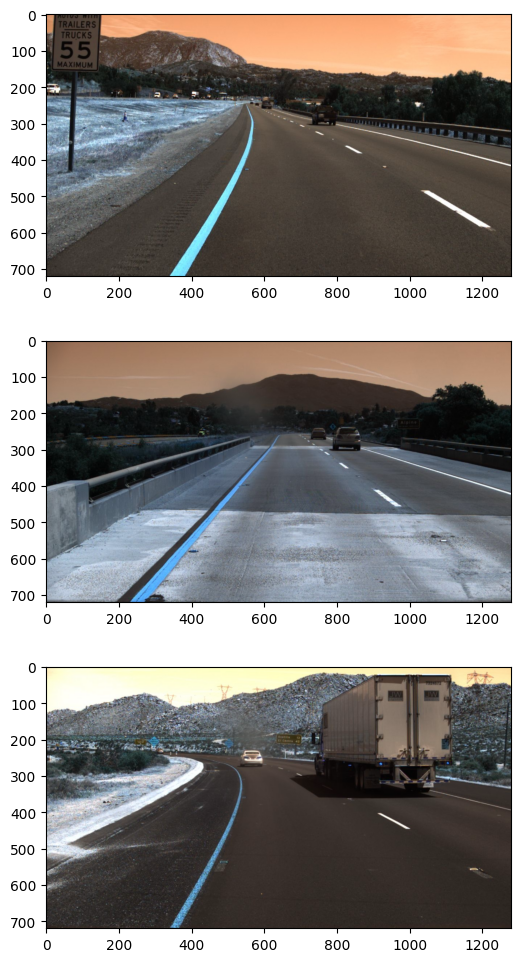

In [98]:
n = len(test_image_list)
plt.subplots(n, 1, figsize=(6, 12))
for i in range(n):
    plt.subplot(n, 1, i + 1)
    plt.imshow(test_image_list[i])

plt.subplots(n, 1, figsize=(6, 12))
for i in range(n):
    lane_detector = LaneDetector(enet=enet)
    test_result = lane_detector(test_image_list[i])
    plt.subplot(n, 1, i + 1)
    plt.imshow(cv2.resize(test_image_list[i], (512, 256)))
    plt.imshow(test_result[0], alpha=0.5)


The model still needs finetuning and debugging.